https://www.kaggle.com/datasets/devansodariya/road-accident-united-kingdom-uk-dataset

In [1]:
# Importing the modules, setting plotting formats and importing the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, time

sns.set_theme()

accidents = pd.read_csv("UK_Accident.csv")
accidents.memory_usage(deep=True).sum()

1806485281

In [2]:
# Creating a function to transform and clean the data as required for analysis.

def tweak_accidents(accidents):
   drop_columns = ["Unnamed: 0", 
                "Accident_Index",
                "Location_Easting_OSGR",
                "Location_Northing_OSGR",
                "Police_Force", 
                "Local_Authority_(District)", 
                "Local_Authority_(Highway)", 
                "1st_Road_Class",
                "1st_Road_Number", 
                "2nd_Road_Class",
                "2nd_Road_Number",
                "Year",
                "Did_Police_Officer_Attend_Scene_of_Accident",
                "LSOA_of_Accident_Location",
                "Junction_Control",
                "Pedestrian_Crossing-Human_Control",
                "Pedestrian_Crossing-Physical_Facilities"]
   
   return (accidents
      .rename(columns={"Speed_limit":"Speed_Limit"})
      .assign(
         Longitude=lambda df_: df_["Longitude"].astype("float32"),
         Latitude=lambda df_: df_["Latitude"].astype("float32"),
         Accident_Severity=lambda df_: df_["Accident_Severity"]
            .map({1: "Most Severe", 2: "Moderate Severity", 3: "Least Severe"})
            .astype("category"),
         Number_of_Vehicles=lambda df_: df_["Number_of_Vehicles"].astype("uint8"),
         Number_of_Casualties=lambda df_: df_["Number_of_Casualties"].astype("uint8"),
         Date=lambda df_: pd.to_datetime(df_["Date"]+" "+df_["Time"], format="%d/%m/%Y %H:%M"),
         Time=lambda df_: pd.to_datetime(df_["Time"], format="%H:%M").dt.time,
         Day_of_Week=lambda df_: df_["Day_of_Week"].astype("uint8"),
         Road_Type=lambda df_: df_["Road_Type"].astype("category"),
         Speed_Limit=lambda df_: df_["Speed_Limit"].astype("uint8"),
         Light_Conditions=lambda df_: df_["Light_Conditions"].astype("category"),
         Weather_Conditions=lambda df_: df_["Weather_Conditions"].astype("category"),
         Road_Surface_Conditions=lambda df_: df_["Road_Surface_Conditions"].astype("category"),
         Special_Conditions_at_Site=lambda df_: df_["Special_Conditions_at_Site"].astype("category"),
         Carriageway_Hazards=lambda df_: df_["Carriageway_Hazards"].astype("category"),
         Urban_or_Rural_Area=lambda df_: df_["Urban_or_Rural_Area"]
            .map({1: "Urban", 2: "Suburban", 3: "Rural"})
            .astype("category")
         )
      .drop(columns=drop_columns)
      .dropna()
      )

In [3]:
# Applying the function

accidents = tweak_accidents(accidents)
accidents.info()
accidents.memory_usage(deep=True).sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1503932 entries, 0 to 1504149
Data columns (total 16 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Longitude                   1503932 non-null  float32       
 1   Latitude                    1503932 non-null  float32       
 2   Accident_Severity           1503932 non-null  category      
 3   Number_of_Vehicles          1503932 non-null  uint8         
 4   Number_of_Casualties        1503932 non-null  uint8         
 5   Date                        1503932 non-null  datetime64[ns]
 6   Day_of_Week                 1503932 non-null  uint8         
 7   Time                        1503932 non-null  object        
 8   Road_Type                   1503932 non-null  category      
 9   Speed_Limit                 1503932 non-null  uint8         
 10  Light_Conditions            1503932 non-null  category      
 11  Weather_Conditions      

126335268

## Accident Severity Trends:

In [4]:
# What is the trend in accident severity over the years?

## Creating a DataFrame showing the count of Accidents by Severity Level across the Years

(accidents
 .resample("Y", on="Date")["Accident_Severity"]
 .value_counts()
 .unstack()
 .reset_index()
 .assign(Date=lambda df_: df_.Date.dt.year)
 .query("Date != 2008")
 .set_index("Date")
 .rename_axis(columns=None))

,Least Severe,Moderate Severity,Most Severe
Date,,,
2005,170710,25014,2913
2006,161257,24943,2926
2007,155050,24316,2714
2009,139485,21995,2057
2010,132235,20440,1731
2011,128683,20982,1797
2012,151192,26481,2037
2013,117424,19621,1607
2014,123988,20676,1658


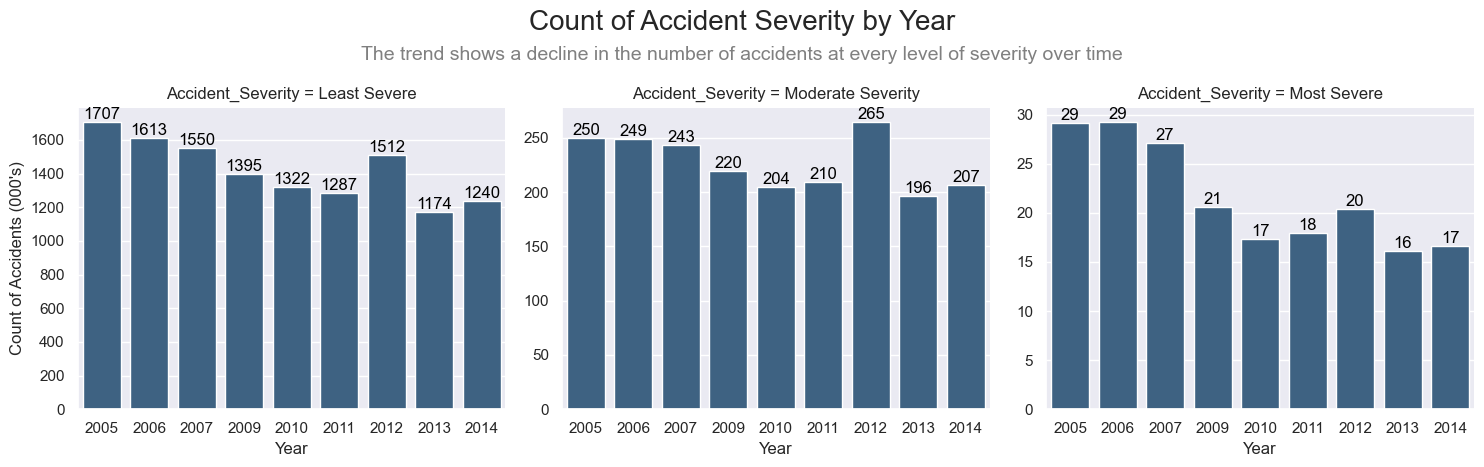

In [5]:
## Plotting the Accident Severity trend by Count and Year

count_severity_by_year = (accidents
 .resample("Y", on="Date")["Accident_Severity"]
 .value_counts().div(100)
 .reset_index(name="Count")
 .assign(Date=lambda df_: df_.Date.dt.year)
 .query("Date != 2008"))

plot_ct_severity_by_year = (sns
 .catplot(data=count_severity_by_year, 
          kind="bar",
          x="Date",
          y="Count",
          col="Accident_Severity",
          sharey=False,
          color="#33638d")
 )

for i, ax in enumerate(plot_ct_severity_by_year.axes.flat):
        ax.set_xlabel("Year")
        if i == 0:
            ax.set_ylabel("Count of Accidents (000's)")
                        
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f"{height:.0f}", (p.get_x() + p.get_width() / 2, height),
                        ha="center", va="bottom", fontsize=12, color="black")


subtitle_text = "The trend shows a decline in the number of accidents at every level of severity over time"

plt.suptitle("Count of Accident Severity by Year", fontsize=20)
plt.figtext(0.5, 0.88, subtitle_text, fontsize=14, ha="center", color="grey")
plt.tight_layout(rect=[0, 0.05, 1, 0.95])


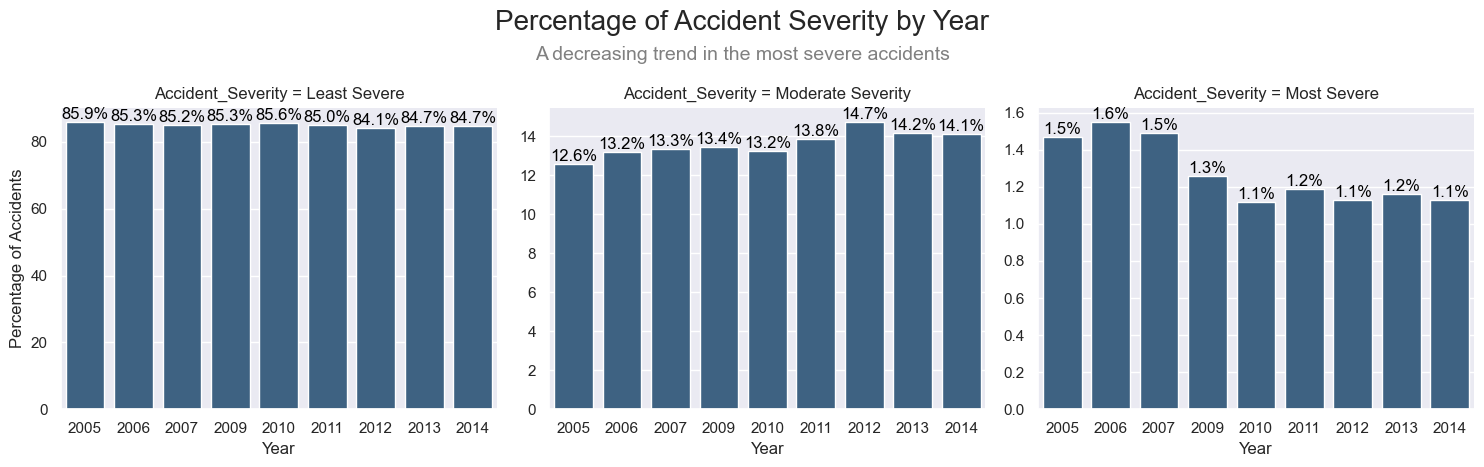

In [6]:
## Plotting the Accident Severity trend by Percentage and Year

total_accidents_by_year = (accidents
 .assign(Date=lambda df_: df_.Date.dt.year)
 .groupby(["Date"])
 .size()
 .reset_index(name="Count")
)

percentage_severity_by_year = (accidents
 .assign(Date=lambda df_: df_.Date.dt.year)
 .groupby(["Date", "Accident_Severity"])
 .size()
 .div(total_accidents_by_year.set_index("Date")["Count"])
 .mul(100)
 .round(2)
 .reset_index(name="Percentage")
)


plot_pct_severity_by_year = (sns
 .catplot(data=percentage_severity_by_year, 
          kind="bar",
          x="Date",
          y="Percentage",
          col="Accident_Severity",
          sharey=False,
          color="#33638d"))

for i, ax in enumerate(plot_pct_severity_by_year.axes.flat):
        ax.set_xlabel("Year")
        if i == 0:
            ax.set_ylabel("Percentage of Accidents")
        
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f"{height:.1f}%", (p.get_x() + p.get_width() / 2, height),
                        ha="center", va="bottom", fontsize=12, color="black")

subtitle_text = "A decreasing trend in the most severe accidents"

plt.suptitle("Percentage of Accident Severity by Year", fontsize=20)
plt.figtext(0.5, 0.88, subtitle_text, fontsize=14, ha="center", color="grey")
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

In [7]:
## Creating a DataFrame showing the changes in the Count of Accidents across the Years

(accidents
 .resample("Y", on="Date").size()
 .reset_index(name="Count")
 .assign(Date=lambda df_: df_.Date.dt.year)
 .query("Date != 2008")
 .assign(Previous_Count=lambda df_: df_.Count - df_.Count.shift(1)))


,Date,Count,Previous_Count
0,2005,198637,NaN
1,2006,189126,-9511.0
2,2007,182080,-7046.0
4,2009,163537,-18543.0
5,2010,154406,-9131.0
6,2011,151462,-2944.0
7,2012,179710,28248.0
8,2013,138652,-41058.0
9,2014,146322,7670.0


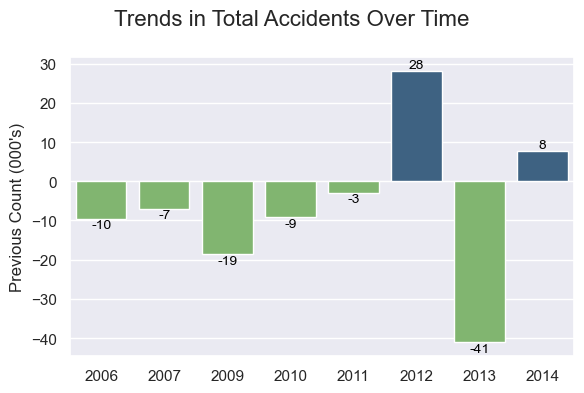

In [8]:
## Plotting the changes in the Count of Accidents across the Years

accident_changes_by_ct = (accidents
 .resample("Y", on="Date").size().div(1000)
 .reset_index(name="Count")
 .assign(Date=lambda df_: df_.Date.dt.year)
 .query("Date != 2008")
 .assign(Previous_Count=lambda df_: df_.Count - df_.Count.shift(1))
 .query("Date != 2005"))


colors = ["#7bc164" if val < 0 else "#33638d" for val in accident_changes_by_ct["Previous_Count"]]

plt.figure(figsize=(6,4))

plot_ct_change_by_year = (sns
      .barplot(
          data=accident_changes_by_ct,
          x="Date", 
          y="Previous_Count",
          palette=colors))

for p in plot_ct_change_by_year.patches:
    height = p.get_height()
    if height >= 0:
        label_position = height
    else:
        label_position = height - 3.2
    plot_ct_change_by_year.annotate(
        f"{height:.0f}", 
        (p.get_x() + p.get_width() / 2, label_position),
        ha="center", 
        va="bottom", 
        fontsize=10, 
        color="black"
    )

plt.suptitle("Trends in Total Accidents Over Time", fontsize=16)
plt.ylabel("Previous Count (000's)")
plt.xlabel("")
plt.tight_layout()

## Day of the Week Analysis:

In [9]:
# Which day of the week witnesses the highest number of accidents?

(accidents
 .assign(Date=lambda df_: df_.Date.dt.strftime("%A"))
 ["Date"]
 .value_counts()[0:1])

Friday    247103
Name: Date, dtype: int64

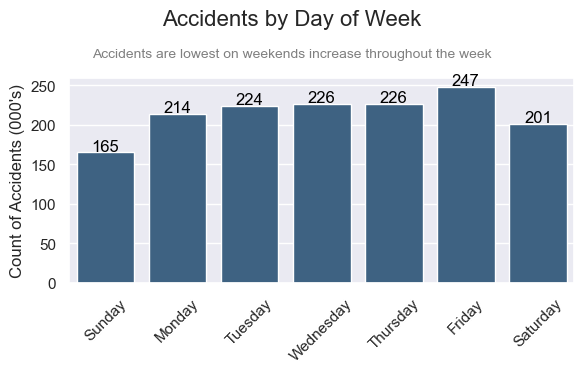

In [10]:
## Plotting the count of accidents by the day of the week

accident_ct_by_day = (accidents
            .assign(Date=lambda df_: df_.Date.dt.strftime("%A"))
            .groupby(["Date", "Day_of_Week"])
            .size().div(1000)
            .reset_index(name="Count")
            .sort_values(by="Day_of_Week")
            )

plt.figure(figsize=(6,4))
plot_day_of_week = (sns
 .barplot(data=accident_ct_by_day,
          x="Date",
          y="Count",
          color="#33638d")
 )

for p in plot_day_of_week.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    plot_day_of_week.annotate(f"{height:.0f}", (x + width/2, y + height + (height/95)), 
                         ha="center", 
                         fontsize=12, 
                         color="black")

subtitle_text = "Accidents are lowest on weekends increase throughout the week"

plt.suptitle("Accidents by Day of Week", fontsize=16)
plt.figtext(0.5, 0.86, subtitle_text, fontsize=10, ha="center", color="grey")
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("Count of Accidents (000's)")
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

## Time Analysis:

In [11]:
# Are there differences in accident frequency during daylight and nighttime?

## Dictionary of Average Sun Rise and Sun Set times by month in the UK
month_times = {
    "January": (time(8, 0, 0), time(15, 0, 0)),
    "February": (time(7, 30, 0), time(16, 30, 0)),
    "March": (time(6, 30, 0), time(17, 30, 0)),
    "April": (time(6, 0, 0), time(20, 0, 0)),
    "May": (time(5, 30, 0), time(20, 30, 0)),
    "June": (time(4, 30, 0), time(21, 30, 0)),
    "July": (time(4, 30, 0), time(21, 30, 0)),
    "August": (time(5, 0, 0), time(20, 0, 0)),
    "September": (time(6, 0, 0), time(19, 0, 0)),
    "October": (time(7, 0, 0), time(18, 0, 0)),
    "November": (time(7, 30, 0), time(16, 30, 0)),
    "December": (time(8, 0, 0), time(15, 30, 0)),
}

light_mask = (
    (accidents["Time"] >= accidents["Date"].dt.month_name().map(month_times).str[0]) &
    (accidents["Time"] <= accidents["Date"].dt.month_name().map(month_times).str[1])
)

accidents["Day_Light"] = "Light"
accidents.loc[~light_mask, "Day_Light"] = "Dark"
accidents["Day_Light"] = accidents["Day_Light"].astype("category")

In [12]:
## Creating a DataFrame showing the count of accidents by Day Light hours and Severity Level

(accidents
 .groupby(["Day_Light", "Accident_Severity"])
 .size()
 .reset_index(name="Count")
 .assign(
        Total_Count=lambda df_: df_.groupby("Day_Light")["Count"].transform("sum"),
        Percentage=lambda df_: ((df_["Count"] / df_["Total_Count"]) * 100).round(2))
 .drop(columns="Total_Count")
 .sort_values("Day_Light", ascending=False)
)

,Day_Light,Accident_Severity,Count,Percentage
3,Light,Least Severe,912478,86.16
4,Light,Moderate Severity,135573,12.80
5,Light,Most Severe,10988,1.04
0,Dark,Least Severe,367546,82.61
1,Dark,Moderate Severity,68895,15.49
2,Dark,Most Severe,8452,1.90


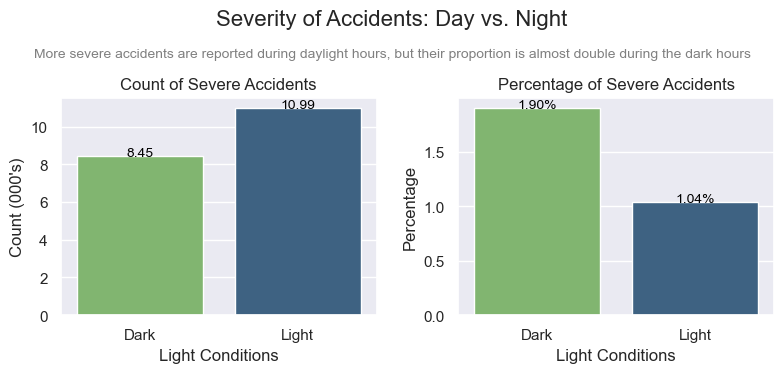

In [13]:
## Plotting reported accidents count and percentage split by Day Light

day_light_accident_comparison = (accidents
 .groupby(["Day_Light", "Accident_Severity"])
 .size().div(1000)
 .reset_index(name="Count")
 .assign(
        Total_Count=lambda df_: df_.groupby("Day_Light")["Count"].transform("sum"),
        Percentage=lambda df_: ((df_["Count"] / df_["Total_Count"]) * 100).round(2))
 .drop(columns="Total_Count")
 .sort_values("Day_Light", ascending=False)
)

fig, axes = plt.subplots(1, 2, figsize=(8,4))

colors = (["#7bc164" if val == "Light" else "#33638d" 
           for val in day_light_accident_comparison
           .query('Accident_Severity == "Most Severe"')["Day_Light"]])

day_light_ct = (sns
.barplot(
    data=day_light_accident_comparison.query('Accident_Severity == "Most Severe"'), 
    x="Day_Light", 
    y="Count",
    ax=axes[0],
    palette=colors))

for p in day_light_ct.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    day_light_ct.annotate(f"{height:.2f}", (x + width/2, y + height), 
                         ha="center", 
                         fontsize=10, 
                         color="black")

day_light_pct = (sns
.barplot(
    data=day_light_accident_comparison.query('Accident_Severity == "Most Severe"'), 
    x="Day_Light", 
    y="Percentage",
    ax=axes[1],
    palette=colors))

for p in day_light_pct.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    day_light_pct.annotate(f"{height:.2f}%", (x + width/2, y + height), 
                         ha="center", 
                         fontsize=10, 
                         color="black")

subtitle_text = "More severe accidents are reported during daylight hours, but"\
                " their proportion is almost double during the dark hours"

axes[0].set_title("Count of Severe Accidents")
axes[0].set_xlabel("Light Conditions")
axes[0].set_ylabel("Count (000's)")
axes[1].set_title("Percentage of Severe Accidents")
axes[1].set_xlabel("Light Conditions")
plt.suptitle("Severity of Accidents: Day vs. Night", fontsize=16)
plt.figtext(0.5, 0.86, subtitle_text, fontsize=10, ha="center", color="grey")
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

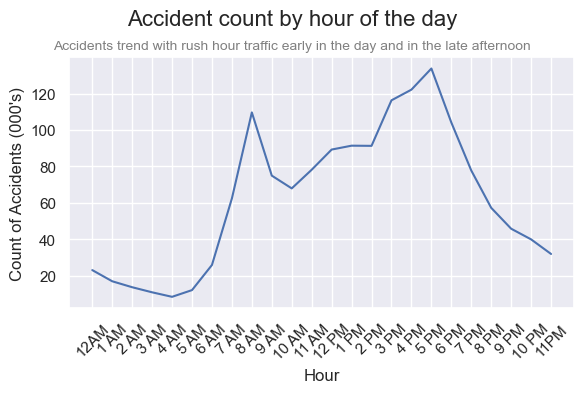

In [14]:
# What are the peak hours for accidents during the day?

accidents_by_hour_ct = (accidents["Date"]
                            .dt.hour
                            .value_counts().div(1000)
                            .reset_index(name="Count")
                            .rename(columns={"index": "Hour"})
                            .sort_values("Hour"))

plt.figure(figsize=(6,4))
x = np.sort(accidents["Date"].dt.hour.unique())
custom_labels = ["12AM", "1 AM", "2 AM", "3 AM", "4 AM", "5 AM", "6 AM", "7 AM",
                 "8 AM", "9 AM", "10 AM", "11 AM", "12 PM", "1 PM","2 PM", "3 PM",
                 "4 PM", "5 PM", "6 PM", "7 PM", "8 PM", "9 PM", "10 PM", "11PM"]

sns.lineplot(data=accidents_by_hour_ct, x="Hour", y="Count")

subtitle_text = "Accidents trend with rush hour traffic early in the day and in the late afternoon"

plt.suptitle("Accident count by hour of the day", fontsize=16)
plt.figtext(0.5, 0.88, subtitle_text, ha="center", color="grey", fontsize=10)
plt.xticks(x, custom_labels, rotation=45)
plt.ylabel("Count of Accidents (000's)")
plt.tight_layout()

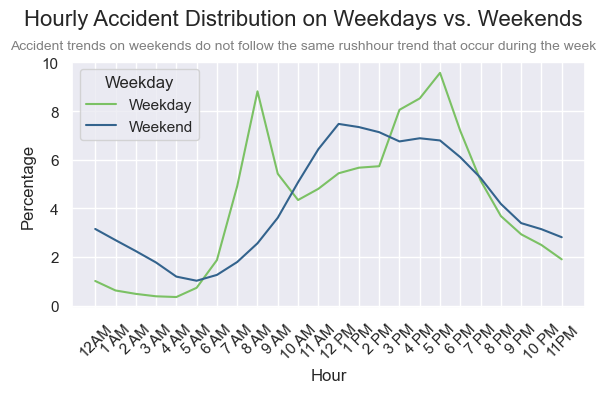

In [15]:
# Is there a difference between peak hours during the week and peak hours on a weekend?

ct_of_weekday = (accidents
                .assign(Weekday=lambda df_: df_["Day_of_Week"]
                            .map({1: "Weekend", 2: "Weekday", 3: "Weekday", 4: "Weekday",
                                5: "Weekday", 6: "Weekday", 7: "Weekend"})
                            .astype("category"))
                .groupby("Weekday").size()
                .reset_index(name="Count")
                )

pct_of_weekday = (accidents
                .assign(Hour=lambda df_: df_["Date"].dt.hour,
                        Weekday=lambda df_: df_["Day_of_Week"]
                            .map({1: "Weekend", 2: "Weekday", 3: "Weekday", 4: "Weekday",
                                5: "Weekday", 6: "Weekday", 7: "Weekend"})
                            .astype("category"))
                .groupby(["Hour", "Weekday"]).size()
                .div(ct_of_weekday.set_index("Weekday")["Count"])
                .mul(100)
                .round(2)
                .reset_index(name="Percentage")
                )

plt.figure(figsize=(6,4))
x = np.sort(accidents["Date"].dt.hour.unique())
custom_labels = ["12AM", "1 AM", "2 AM", "3 AM", "4 AM", "5 AM", "6 AM", "7 AM",
                 "8 AM", "9 AM", "10 AM", "11 AM", "12 PM", "1 PM","2 PM", "3 PM",
                 "4 PM", "5 PM", "6 PM", "7 PM", "8 PM", "9 PM", "10 PM", "11PM"]

sns.lineplot(data=pct_of_weekday, x="Hour", y="Percentage", hue="Weekday", palette=["#7bc164", "#33638d"])

subtitle_text = "Accident trends on weekends do not follow the same rushhour trend that occur during the week"

plt.suptitle("Hourly Accident Distribution on Weekdays vs. Weekends", fontsize=16)
plt.figtext(0.5, 0.88, subtitle_text, ha="center", fontsize=10, color="grey")
plt.xticks(x, custom_labels, rotation=45)
plt.tight_layout()

## Speed Limit Impact:

In [16]:
# Which road speed limit has the highest proportion of severe accidents?

speed_limit_severity_ct = (accidents
            .groupby(["Accident_Severity"])["Speed_Limit"]
            .value_counts()
            .unstack())

speed_limit_severity_pct = (speed_limit_severity_ct
                        .div(speed_limit_severity_ct.sum(axis=0), axis=1).mul(100)
                        .T
                        .stack()
                        .reset_index(["Speed_Limit", "Accident_Severity"])
                        .rename(columns={0: "Percentage"})
                    )

speed_limit_severity_pct[speed_limit_severity_pct["Accident_Severity"] == "Most Severe"].iloc[0:1]

## While the actual number of accidents at the speed limit 10mph is low, 
## the proportion of accidents that are deemed to be most severe are highest
## at this speed limit.

,Speed_Limit,Accident_Severity,Percentage
2,10,Most Severe,14.285714


In [17]:
## In order to focus our analysis on typical data points, I have filtered out
## the low-frequency accidents occurring below 20mph

speed_limit_severity_pct = (accidents
            .query("Speed_Limit >= 20")
            .groupby(["Accident_Severity"])["Speed_Limit"]
            .value_counts()
            .unstack())

speed_limit_severity_pct = (speed_limit_severity_pct
                        .div(speed_limit_severity_pct.sum(axis=0), axis=1).mul(100)
                        .T
                        .stack()
                        .reset_index(["Speed_Limit", "Accident_Severity"])
                        .rename(columns={0: "Percentage"})
                    )

(speed_limit_severity_pct[speed_limit_severity_pct["Accident_Severity"] == "Most Severe"]
.sort_values("Percentage", ascending=False)
.iloc[0:1])

,Speed_Limit,Accident_Severity,Percentage
14,60,Most Severe,3.140038


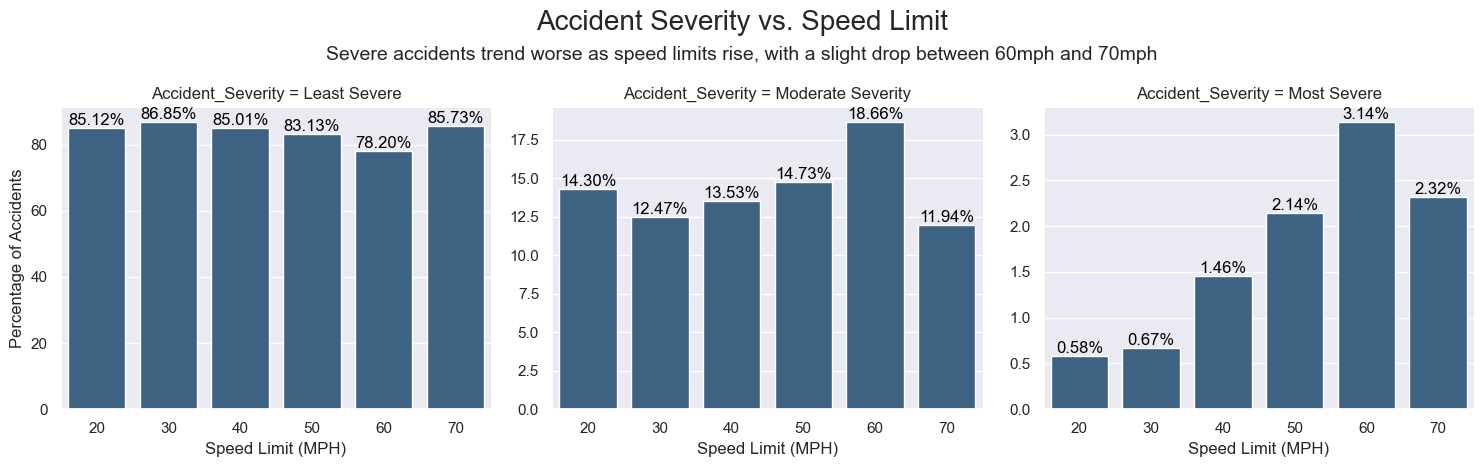

In [18]:
## Plotting Percentage of Accidents occuring at each Speed Limit by Severity

plot_speed_limit_severity_pct = (sns
 .catplot(
    data=speed_limit_severity_pct,
    kind="bar",
    x="Speed_Limit",
    y="Percentage",
    col="Accident_Severity",
    sharey=False,
    color="#33638d")
)

for i, ax in enumerate(plot_speed_limit_severity_pct.axes.flat):
        ax.set_xlabel("Speed Limit (MPH)")
        if i == 0:
            ax.set_ylabel("Percentage of Accidents")
            
        for p in ax.patches:
            height = p.get_height()
            offset = - 1
            ax.annotate(f"{height:.2f}%", (p.get_x() + p.get_width() / 2, height),
                        ha="center", va="bottom", fontsize=12, color="black")


subtitle_text = "Severe accidents trend worse as speed limits rise, with"\
                " a slight drop between 60mph and 70mph"
                            
plt.suptitle("Accident Severity vs. Speed Limit", fontsize=20)
plt.figtext(0.5, 0.88, subtitle_text, fontsize=14, ha="center")
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

## Road Surface and Weather Conditions:

* Do specific road surface conditions or special conditions at sites lead to more accidents?
* What types of hazards are most associated with accidents?

In [19]:
(accidents
                .groupby(["Road_Surface_Conditions", "Accident_Severity"])
                .size()
                .reset_index(name="Count")
                .assign(
                    Total_Count=lambda df_: df_.groupby(["Road_Surface_Conditions"])["Count"].transform("sum"),
                    Percentage=lambda df_: ((df_["Count"] / df_["Total_Count"]) *100).round(2),
                    Road_Surface_Conditions=lambda df_: df_["Road_Surface_Conditions"]
                    .str.split(" ", expand=True)[0])
                .drop(columns="Total_Count")
 )["Road_Surface_Conditions"].value_counts()

Dry          3
Flood        3
Frost/Ice    3
Normal       3
Snow         3
Wet/Damp     3
Name: Road_Surface_Conditions, dtype: int64

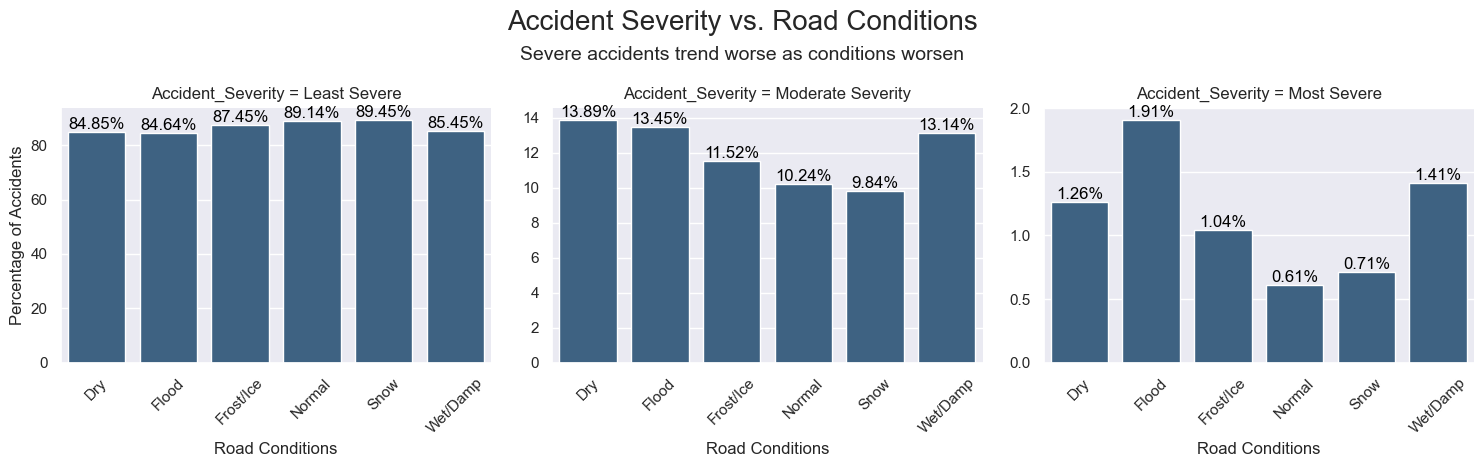

In [20]:
accidents_by_road_conditions_ct = (accidents
                .groupby(["Road_Surface_Conditions", "Accident_Severity"])
                .size()
                .reset_index(name="Count")
                .assign(
                    Total_Count=lambda df_: df_.groupby(["Road_Surface_Conditions"])["Count"].transform("sum"),
                    Percentage=lambda df_: ((df_["Count"] / df_["Total_Count"]) *100).round(2),
                    Road_Surface_Conditions=lambda df_: df_["Road_Surface_Conditions"]
                    .str.split(" ", expand=True)[0])
                .drop(columns="Total_Count")
 )

plot_road_conditions_severity_pct = (sns.catplot(data=accidents_by_road_conditions_ct, 
             kind="bar", 
             x="Road_Surface_Conditions", 
             y="Percentage", 
             col="Accident_Severity",
             sharey=False,
             color="#33638d"))

for i, ax in enumerate(plot_road_conditions_severity_pct.axes.flat):
        ax.set_xlabel("Road Conditions")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45) 
        if i == 0:
            ax.set_ylabel("Percentage of Accidents")
            
        for p in ax.patches:
            height = p.get_height()
            offset = - 1
            ax.annotate(f"{height:.2f}%", (p.get_x() + p.get_width() / 2, height),
                        ha="center", va="bottom", fontsize=12, color="black")


subtitle_text = "Severe accidents trend worse as conditions worsen"
                            
plt.suptitle("Accident Severity vs. Road Conditions", fontsize=20)
plt.figtext(0.5, 0.88, subtitle_text, fontsize=14, ha="center")
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

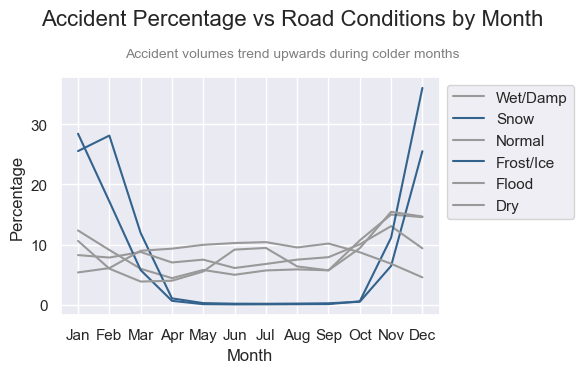

In [21]:
# Define custom colors for specific road conditions
custom_colors = {
    "Flood": "#999999", "Snow": "#33638d", "Dry": "#999999",
    "Frost/Ice": "#33638d", "Wet/Damp": "#999999", "Normal": "#999999"}

road_surface_accidents_by_month = (
    accidents
    .assign(
        Month_Number=lambda df_: df_["Date"].dt.month,
        Month_Name=lambda df_: df_["Date"].dt.month_name()
            .str[:3],
        Road_Surface_Conditions=lambda df_: df_["Road_Surface_Conditions"]
            .str.split(" ", expand=True)[0]
    )
    .groupby(["Month_Name", "Month_Number", "Road_Surface_Conditions"])
    .size()
    .reset_index(name="Count")
    .assign(
        Total_Count=lambda df_: df_.groupby(["Road_Surface_Conditions"])["Count"].transform("sum"),
        Percentage=lambda df_: ((df_["Count"] / df_["Total_Count"]) * 100).round(2)
    )
    .drop(columns="Total_Count")
    .sort_values(by="Month_Number")
)

plt.figure(figsize=(6, 4))
sns.lineplot(
    data=road_surface_accidents_by_month,
    x="Month_Name",
    y="Percentage",
    hue="Road_Surface_Conditions",
    palette=custom_colors
)

subtitle_text = "Accident volumes trend upwards during colder months"

plt.suptitle("Accident Percentage vs Road Conditions by Month", fontsize=16)
plt.figtext(0.5, 0.86, subtitle_text, fontsize=10, ha="center", color="grey")
plt.xlabel("Month")
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

In [22]:
# "What is the distribution of accident severity levels based on wind conditions (windy or not)
# and different speed limits (e.g., 20 mph and above) in the dataset, and how do these distributions
# vary across different combinations of wind conditions and speed limits?"

accident_severity_by_wind = (accidents
        .query("Speed_Limit >= 20")
        .assign(Windy=lambda df_: df_["Weather_Conditions"]
                .str.contains("with high winds", case=False, regex=True))
        .groupby(["Accident_Severity", "Windy", "Speed_Limit"]).size()
        .reset_index(name="Count")
        .assign(
                Total_Count=lambda df_: df_.groupby(["Accident_Severity", "Windy"])["Count"].transform("sum"),
                Percentage=lambda df_: ((df_["Count"] / df_["Total_Count"]) *100).round(2))
        .drop(columns="Total_Count")
        )

accident_severity_by_wind

,Accident_Severity,Windy,Speed_Limit,Count,Percentage
0,Least Severe,False,20,14296,1.15
1,Least Severe,False,30,822541,66.06
2,Least Severe,False,40,101209,8.13
3,Least Severe,False,50,39247,3.15
4,Least Severe,False,60,178388,14.33
5,Least Severe,False,70,89514,7.19
6,Least Severe,True,20,306,0.88
7,Least Severe,True,30,18365,52.76
8,Least Severe,True,40,2832,8.14
9,Least Severe,True,50,1309,3.76


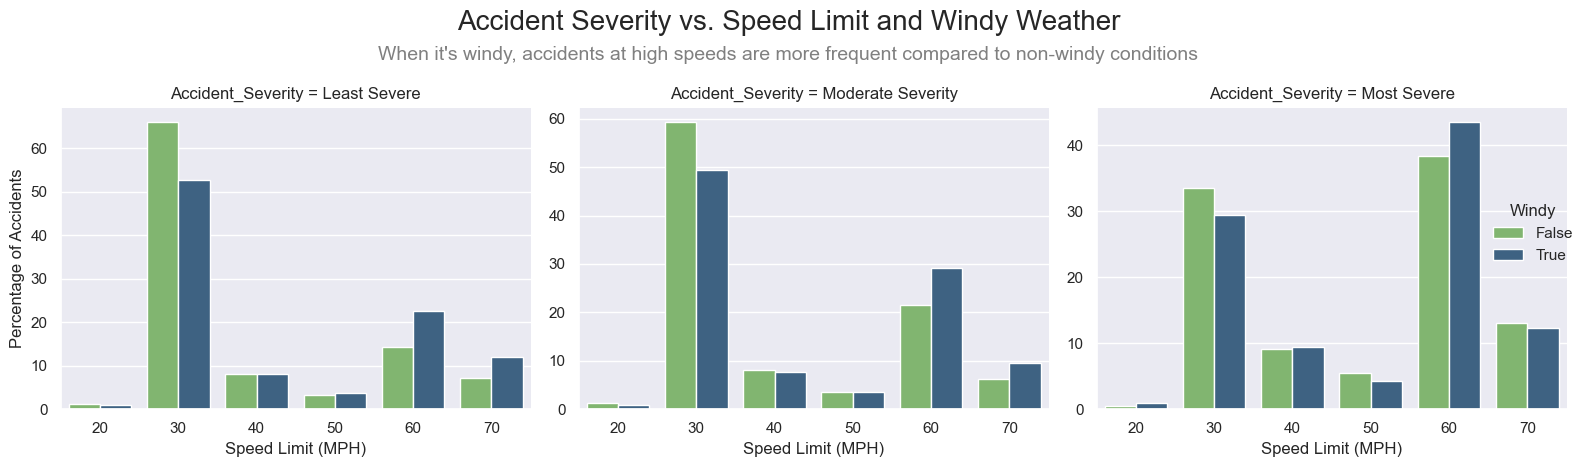

In [23]:
plot_accident_severity_by_wind = (sns
 .catplot(
    data=accident_severity_by_wind, 
    kind="bar", 
    x="Speed_Limit", 
    y="Percentage", 
    hue="Windy", 
    col="Accident_Severity",
    sharey=False,
    palette=["#7bc164", "#33638d"]))

for i, ax in enumerate(plot_accident_severity_by_wind.axes.flat):
        ax.set_xlabel("Speed Limit (MPH)")
        if i == 0:
            ax.set_ylabel("Percentage of Accidents")

subtitle_text = "When it's windy, accidents at high speeds are more frequent compared to non-windy"\
                " conditions"
                            
plt.suptitle("Accident Severity vs. Speed Limit and Windy Weather", fontsize=20)
plt.figtext(0.5, 0.88, subtitle_text, fontsize=14, ha="center", color="grey")
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

## Urban vs. Rural Analysis:

In [24]:
# Are accidents more common in urban or rural areas?

(accidents["Urban_or_Rural_Area"]
 .value_counts()
 .reset_index(name="Count")
 .rename(columns={"index": "Area"})
 .assign(
     Total_Count=lambda df_: df_["Count"].sum(),
     Percentage=lambda df_: ((df_["Count"] / df_["Total_Count"]) *100).round(3))
 .drop(columns="Total_Count"))

,Area,Count,Percentage
0,Urban,971946,64.627
1,Suburban,531951,35.371
2,Rural,35,0.002


In [25]:
# Do accident severity levels differ between urban and rural settings?

accidents_by_area = (accidents
 .groupby(["Urban_or_Rural_Area", "Accident_Severity"])
 .size()
 .reset_index(name="Count")
 .assign(
     Total_Count=lambda df_: df_.groupby("Urban_or_Rural_Area")["Count"].transform("sum"),
     Percentage=lambda df_: ((df_["Count"] / df_["Total_Count"]) *100).round(2))
 .drop(columns="Total_Count"))

accidents_by_area

,Urban_or_Rural_Area,Accident_Severity,Count,Percentage
0,Rural,Least Severe,32,91.43
1,Rural,Moderate Severity,3,8.57
2,Rural,Most Severe,0,0.00
3,Suburban,Least Severe,434615,81.70
4,Suburban,Moderate Severity,84839,15.95
5,Suburban,Most Severe,12497,2.35
6,Urban,Least Severe,845377,86.98
7,Urban,Moderate Severity,119626,12.31
8,Urban,Most Severe,6943,0.71


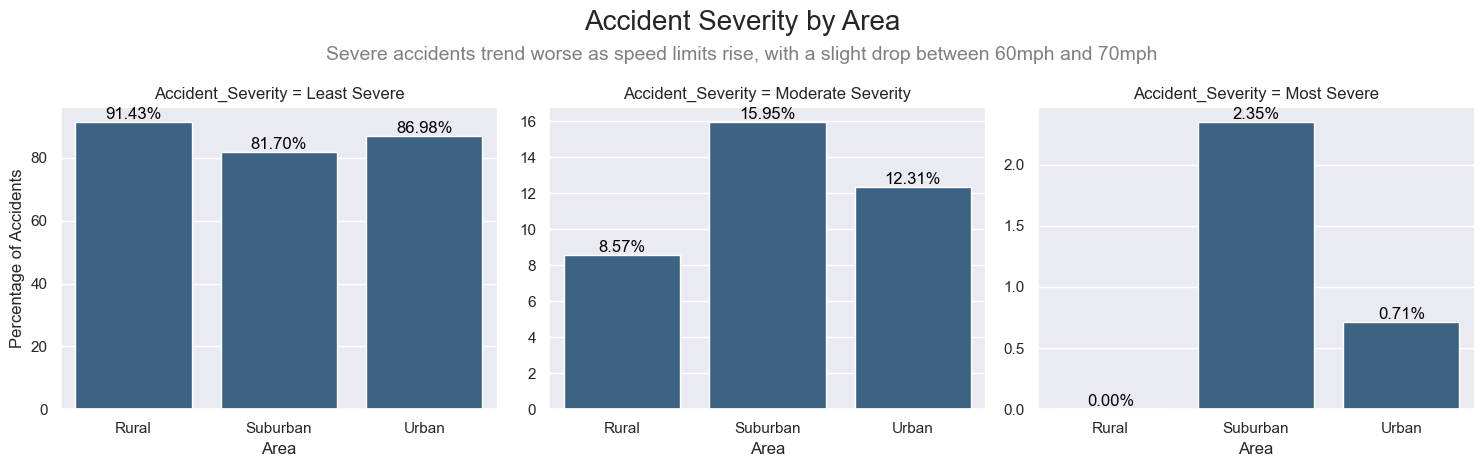

In [26]:
by_area = sns.catplot(
    data=accidents_by_area, 
    kind="bar", 
    x="Urban_or_Rural_Area", 
    y="Percentage", 
    col="Accident_Severity",
    color="#33638d",
    sharey=False)

for i, ax in enumerate(by_area.axes.flat):
        ax.set_xlabel("Area")
        if i == 0:
            ax.set_ylabel("Percentage of Accidents")
            
        for p in ax.patches:
            height = p.get_height()
            offset = - 1
            ax.annotate(f"{height:.2f}%", (p.get_x() + p.get_width() / 2, height),
                        ha="center", va="bottom", fontsize=12, color="black")

subtitle_text = "Severe accidents trend worse as speed limits rise, with"\
                " a slight drop between 60mph and 70mph"
                            
plt.suptitle("Accident Severity by Area", fontsize=20)
plt.figtext(0.5, 0.88, subtitle_text, fontsize=14, ha="center", color="grey")
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

Text(0.5, 33.000000000000014, 'Month')

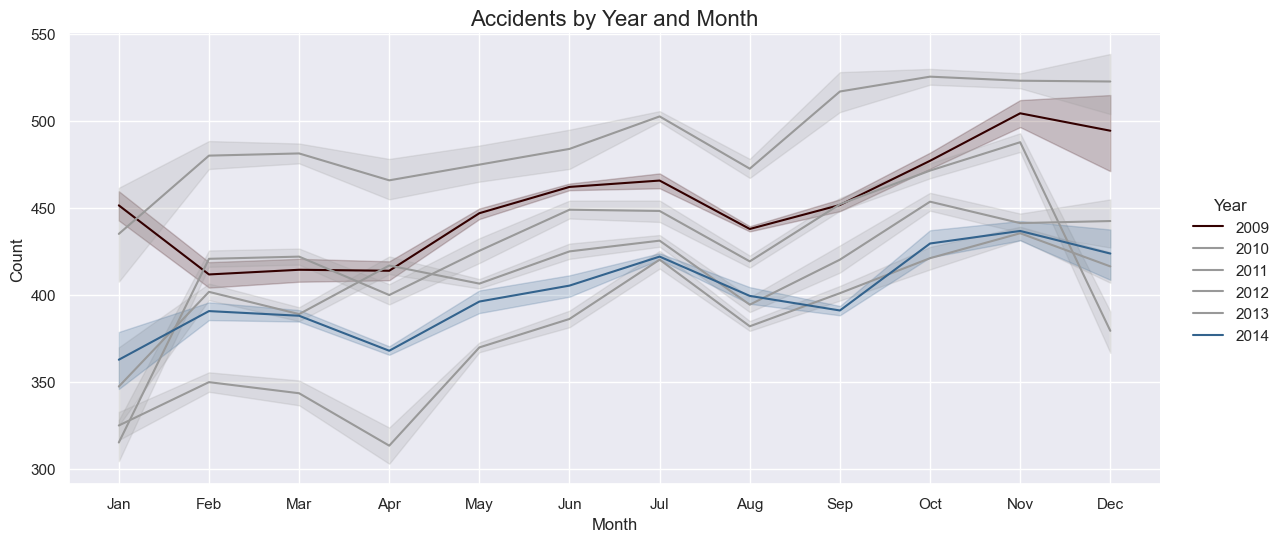

In [31]:
accidents_by_year_and_month = (accidents[["Date", "Longitude"]]
 .query('Date >= "2008"')
 .groupby(pd.Grouper(key="Date", freq="D"))
 .count()
 .rolling(15)
 .mean()
 .reset_index()
 .assign(Year=lambda df_: df_["Date"].dt.year,
         Month=lambda df_: df_["Date"].dt.month,
         Month_Name=lambda df_: df_["Date"].dt.month_name().str[:3],
         Count=lambda df_: df_["Longitude"])
 )

custom_colors = {
    2009: "#330000", 2010: "#999999", 2011: "#999999",
    2012: "#999999", 2013: "#999999", 2014: "#33638d"}

accidents_by_year_and_month_plot = sns.relplot(data=accidents_by_year_and_month, 
            kind="line", 
            x="Month_Name", 
            y="Count",
            hue="Year",
            height=6, 
            aspect=2,
            palette=custom_colors)

plt.tight_layout(rect=[0, 0.05, 0.92, 0.95])
plt.title("Accidents by Year and Month", fontsize=16)
plt.xlabel("Month")

Text(0.5, 33.000000000000014, 'Month')

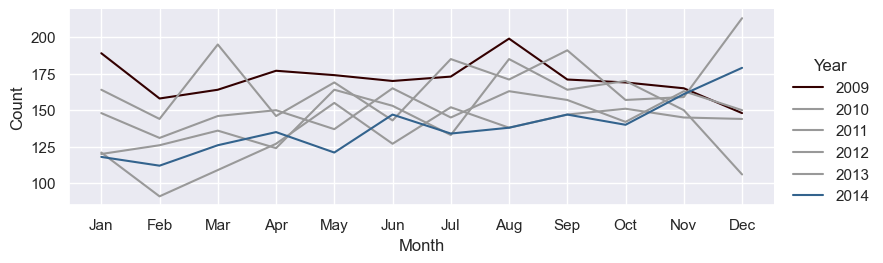

In [28]:
toplot = (accidents
 .query('Date >= "2008" and Accident_Severity == "Most Severe"')
 .assign(Month_Number=lambda df_: df_["Date"].dt.month,
         Month_Name=lambda df_: df_["Date"].dt.month_name().str[:3],
         Year=lambda df_: df_["Date"].dt.year)
 .groupby(["Year", "Month_Number", "Month_Name"])
 .size()
 .reset_index(name="Count"))

custom_colors = {
    2009: "#330000", 2010: "#999999", 2011: "#999999",
    2012: "#999999", 2013: "#999999", 2014: "#33638d"}

sns.relplot(data=toplot, 
            kind="line", 
            x="Month_Name", 
            y="Count",
            hue="Year",
            height=4,
            aspect=2,
            palette=custom_colors)

plt.tight_layout(rect=[0, 0.25, 0.90, 0.95])
plt.xlabel("Month")